### DEA模型结果分析
1. 效益分析
    - 综合技术效益(overall efficiency, OE)反映的是决策单元在一定(最优规模时) 投入要素的生产效率，
    是对决策单元的资源配置能力、资源使用效率等多方面能力的综合衡量与评价(?)
    - 技术效益(technical efficiency, TE)是企业由于管理和技术等因素影响的生产效率(?)
    - 规模效益(scale efficiency, SE)是由于企业规模因素影响的生产效率(?)
    这三个效益满足关系式子：$$OE=TE*SE$$
    
    > 综合技术效益 = 1，表示该决策单元的投入产出是综合有效的，即同时技术有效和规模有效。技术效益 = 1，规模效益 < 1，表示在目前的技术水平上，其投入资源的使用是有效率的，未能达到综合有效的根本原因在于其规模无效，因此其改革的重点在于如何更好地发挥其规模效益 
2. 有效性分析
    
    CCR 模式下 DEA 效率评估模型所得到的最优解 $O E_k$ 是决策单元 $k$ 的 “综合技术效益" 。根据 $O E_k$ 取值不同， 将综合效益评估分为以下三种情况:

    - 若 $O E_k=1, s_i^{-}, s_j^{+}=0 \forall i, j$ ，说明决策单元是 “DEA 强有效" 的，即任何一项投入的 数量都无法减少，除非减少产出或增加另外一种投入的数量；任何一种产出的数量都无法增加， 除非增加投入的数量或减少另外一种产出的数量。即：同时达到技术有效和规模有效
    - 若 $O E_k=1$, 某一 $s_i^{-}$或 $s_j^{+}$为 0 ，说明决策单元是 “DEA 弱有效" 的，无法等比例减少各项 投入的数量，除非减少产出的数量；无法等比例增加各项产出的数量，除非增加投入的数量。 即：技术有效和规模有效只满足一个
    - 若 $O E_k<1$ ，说明决策单元是 “非 DEA 有效" 的，存在资源浪费现象（没有合理利用资 源），既不是效率最佳也不是规模最佳

    对 "DEA 弱有效" 的决策按照 $s_i^{-}, s_j^{+}$的冗余情况进行调整，使之变得 "DEA 强有效" 。
3. 规模报酬分析(?)

    在不同的生产规模下，规模报酬将会随之改变。
    
    生产规模小时，投入产出比会随着规模增加而迅速提升，称为规模报酬递增(Increasing Returns to Scale, IRS)；
    
    当生产达到高峰期时，产出与规模成正比而达到最适生产规模，称为规模报酬固定；
    
    当生产规模过于庞大时，产出减缓，则称为规模报酬递减(Decreasing Returns to Scale, DRS)，也就是投入增加时，产出增加的比例会少于投入增加的比例。

In [5]:
import gurobipy
import pandas as pd

# 分页显示数据, 设置为 False 不允许分页
pd.set_option('display.expand_frame_repr', False)

# 最多显示的列数, 设置为 None 显示全部列
pd.set_option('display.max_columns', None)

# 最多显示的行数, 设置为 None 显示全部行
pd.set_option('display.max_rows', None)

class DEA(object):
	def __init__(self, DMUs_Name, X, Y, AP=False):
		self.m1, self.m1_name, self.m2, self.m2_name, self.AP = X.shape[1], X.columns.tolist(), Y.shape[1], Y.columns.tolist(), AP
		self.DMUs, self.X, self.Y = gurobipy.multidict({DMU: [X.loc[DMU].tolist(), Y.loc[DMU].tolist()] for DMU in DMUs_Name})
		print(f'DEA(AP={AP}) MODEL RUNING...')

	def __CCR(self):
		for k in self.DMUs:
			MODEL = gurobipy.Model()
			OE, lambdas, s_negitive, s_positive = MODEL.addVar(), MODEL.addVars(self.DMUs),  MODEL.addVars(self.m1), MODEL.addVars(self.m2)
			MODEL.update()
			MODEL.setObjectiveN(OE, index=0, priority=1)
			MODEL.setObjectiveN(-(sum(s_negitive) + sum(s_positive)), index=1, priority=0)
			MODEL.addConstrs(gurobipy.quicksum(lambdas[i] * self.X[i][j] for i in self.DMUs if i != k or not self.AP) + s_negitive[j] == OE * self.X[k][j] for j in range(self.m1))
			MODEL.addConstrs(gurobipy.quicksum(lambdas[i] * self.Y[i][j] for i in self.DMUs if i != k or not self.AP) - s_positive[j] == self.Y[k][j] for j in range(self.m2))
			MODEL.setParam('OutputFlag', 0)
			MODEL.optimize()
			self.Result.at[k, ('效益分析', '综合技术效益(CCR)')] = MODEL.objVal
			self.Result.at[k, ('规模报酬分析', '有效性')] = '非 DEA 有效' if MODEL.objVal < 1 else 'DEA 弱有效' if s_negitive.sum().getValue() + s_positive.sum().getValue() else 'DEA 强有效'
			self.Result.at[k, ('规模报酬分析', '类型')] = '规模报酬固定' if lambdas.sum().getValue() == 1 else '规模报酬递增' if lambdas.sum().getValue() < 1 else '规模报酬递减'
			for m in range(self.m1):
				self.Result.at[k, ('差额变数分析', f'{self.m1_name[m]}')] = s_negitive[m].X
				self.Result.at[k, ('投入冗余率',  f'{self.m1_name[m]}')] = 'N/A' if self.X[k][m] == 0 else s_negitive[m].X / self.X[k][m]
			for m in range(self.m2):
				self.Result.at[k, ('差额变数分析', f'{self.m2_name[m]}')] = s_positive[m].X
				self.Result.at[k, ('产出不足率', f'{self.m2_name[m]}')] = 'N/A' if self.Y[k][m] == 0 else s_positive[m].X / self.Y[k][m]
		return self.Result

	def __BCC(self):
		for k in self.DMUs:
			MODEL = gurobipy.Model()
			TE, lambdas = MODEL.addVar(), MODEL.addVars(self.DMUs)
			MODEL.update()
			MODEL.setObjective(TE, sense=gurobipy.GRB.MINIMIZE)
			MODEL.addConstrs(gurobipy.quicksum(lambdas[i] * self.X[i][j] for i in self.DMUs if i != k or not self.AP) <= TE * self.X[k][j] for j in range(self.m1))
			MODEL.addConstrs(gurobipy.quicksum(lambdas[i] * self.Y[i][j] for i in self.DMUs if i != k or not self.AP) >= self.Y[k][j] for j in range(self.m2))
			MODEL.addConstr(gurobipy.quicksum(lambdas[i] for i in self.DMUs if i != k or not self.AP) == 1)
			MODEL.setParam('OutputFlag', 0)
			MODEL.optimize()
			self.Result.at[k, ('效益分析', '技术效益(BCC)')] = MODEL.objVal if MODEL.status == gurobipy.GRB.Status.OPTIMAL else 'N/A'
		return self.Result

	def dea(self):
		columns_Page = ['效益分析'] * 3 + ['规模报酬分析'] * 2 + ['差额变数分析'] * (self.m1 + self.m2) + ['投入冗余率'] * self.m1 + ['产出不足率'] * self.m2
		columns_Group = ['技术效益(BCC)', '规模效益(CCR/BCC)', '综合技术效益(CCR)','有效性', '类型'] + (self.m1_name + self.m2_name) * 2
		self.Result = pd.DataFrame(index=self.DMUs, columns=[columns_Page, columns_Group])
		self.__CCR()
		self.__BCC()
		self.Result.loc[:, ('效益分析', '规模效益(CCR/BCC)')] = self.Result.loc[:, ('效益分析', '综合技术效益(CCR)')] / self.Result.loc[:,('效益分析', '技术效益(BCC)')]
		return self.Result

	def analysis(self, file_name=None):
		Result = self.dea()
		file_name = 'DEA 数据包络分析报告.xlsx' if file_name is None else f'\\{file_name}.xlsx'
		Result.to_excel(file_name, 'DEA 数据包络分析报告')

In [6]:
data = pd.DataFrame({1990: [14.40, 0.65, 31.30, 3621.00, 0.00], 1991: [16.90, 0.72, 32.20, 3943.00, 0.09],1992: [15.53, 0.72, 31.87, 4086.67, 0.07], 1993: [15.40, 0.76, 32.23, 4904.67, 0.13],
1994: [14.17, 0.76, 32.40, 6311.67, 0.37], 1995: [13.33, 0.69, 30.77, 8173.33, 0.59],
1996: [12.83, 0.61, 29.23, 10236.00, 0.51], 1997: [13.00, 0.63, 28.20, 12094.33, 0.44],
1998: [13.40, 0.75, 28.80, 13603.33, 0.58], 1999: [14.00, 0.84, 29.10, 14841.00, 1.00]},
index=['政府财政收入占 GDP 的比例/%', '环保投资占 GDP 的比例/%', '每千人科技人员数/人', '人均 GDP/元', '城市环境质量指数']).T

X = data[['政府财政收入占 GDP 的比例/%', '环保投资占 GDP 的比例/%', '每千人科技人员数/人']]
Y = data[['人均 GDP/元', '城市环境质量指数']]

dea = DEA(DMUs_Name=data.index, X=X, Y=Y)
dea.analysis()	# dea 分析并输出表格
print(dea.dea()) # dea 分析，不输出结果

DEA(AP=False) MODEL RUNING...
          效益分析                              规模报酬分析                    差额变数分析                                                           投入冗余率                                产出不足率          
     技术效益(BCC) 规模效益(CCR/BCC) 综合技术效益(CCR)       有效性      类型 政府财政收入占 GDP 的比例/% 环保投资占 GDP 的比例/% 每千人科技人员数/人 人均 GDP/元  城市环境质量指数 政府财政收入占 GDP 的比例/% 环保投资占 GDP 的比例/% 每千人科技人员数/人  人均 GDP/元  城市环境质量指数
1990  0.938462      0.309213    0.290184  非 DEA 有效  规模报酬递增          0.286499             0.0   0.639787      0.0  0.131734          0.019896             0.0    0.02044       0.0       N/A
1991  0.875776      0.325833    0.285357  非 DEA 有效  规模报酬递增          0.586141             0.0        0.0      0.0   0.05389          0.034683             0.0        0.0       0.0  0.598781
1992  0.884845      0.335456    0.296826  非 DEA 有效  规模报酬递增           0.24146             0.0        0.0      0.0  0.084437          0.015548             0.0        0.0       0.0  1.206239
1993  0.874961      0.391463  

# 数据包络分析
1. 【DEA 目的】：在多投入多产出的情况下，评估某几个对象（组织或单位）的绩效。
2. 【绩效】：表现为以较少的投入获得较多的产出的能力
3. 【投入项】&【产出项】：对目标分别为负向影响与正向影响
4. 【决策单元】：被评估的对象，记作 DMU


5. 【多投入多产出问题】的引入：以工厂为例，有 ABCDEFGH 8个工厂，要分析其生产效率，目的是从中选出绩效最好的一个。

    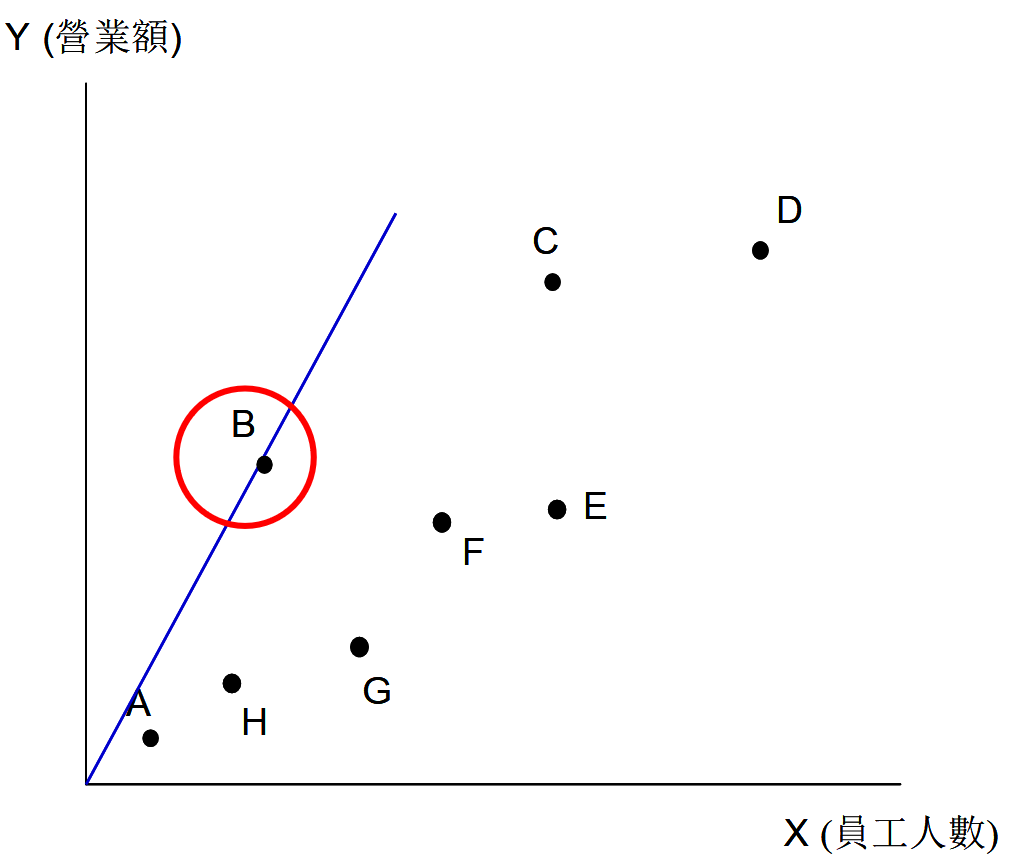
    
    如果投入仅定义为员工人数，产出仅定义为营业额，那么以这两个指标为轴画图，图上点与原点连线斜率最高的，就能视作是效率最高，即绩效最好。

    但是有的工厂可能抗议，一方面投入而言，他们工厂土地面积更大，拥有更多先进的设备，另一方面产出而言，产品的质量以及生产量也应当纳入考核。

    因此就出现了多投入多产出问题：
    1. 应该如何衡量【决策单位】的效率，如何计算，
    2. 如何找到评价最高、衡量结果最优的【决策单位】，
    3. 如何分析评价不高的【决策单位】，投入项应该减少什么属性或者产出项应该提高哪些，提出具体的改善方向。


6. 对第 $k$ 个决策单元效率的衡量：【相对效率】（后面解释什么叫相对效率）
7. 【效率前缘】：由“效率”最高的 $DMU$ 构成（辅助相对效率用）

    投入仅为员工人数($X$)，产出定为营业额($Y_1$)和生产量($Y_2$)，画图如下：
    
    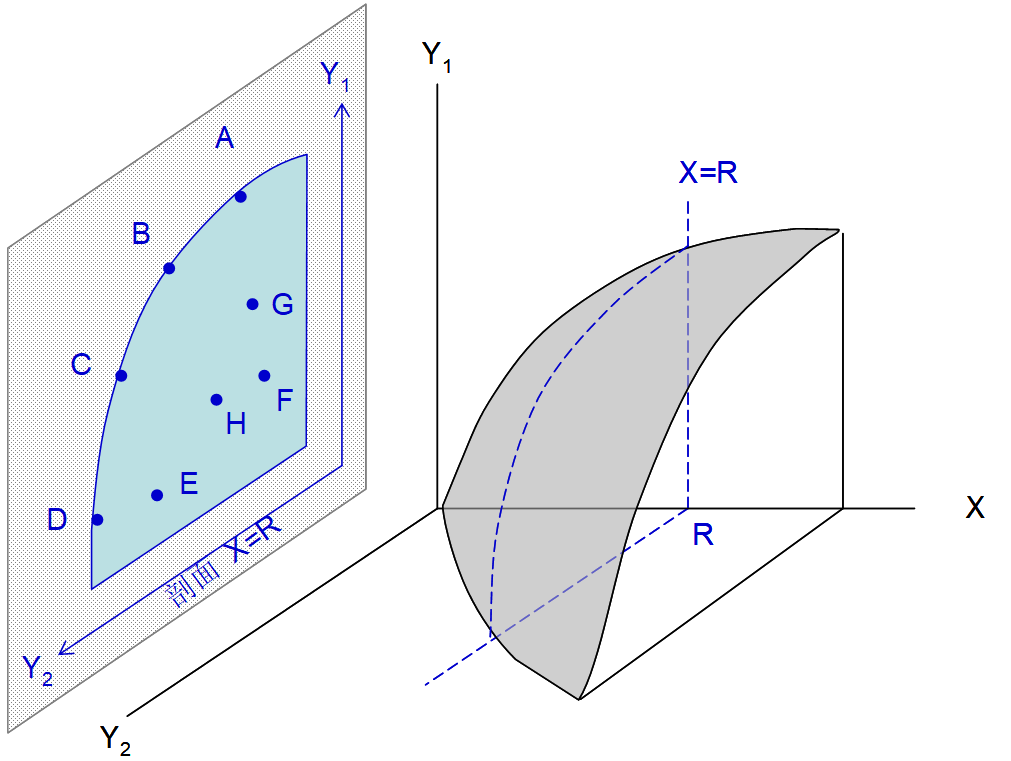

    阴影部分称作效率前缘。
    
    但理应是长成差不多下面这样的对吧（后面解释）：

    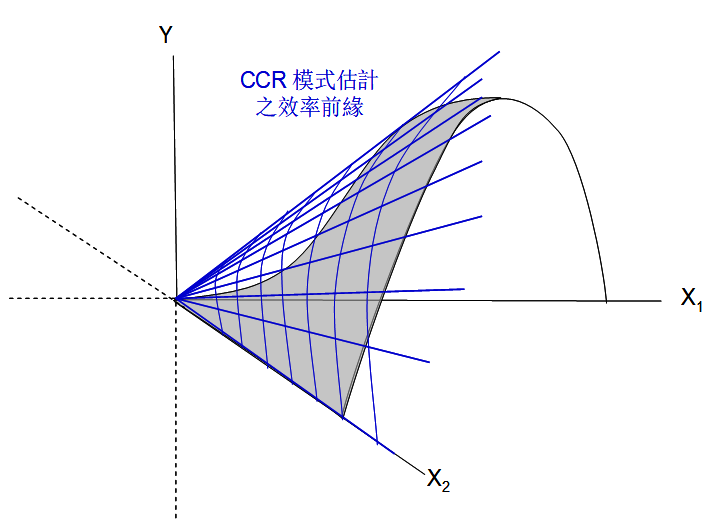

**理解相对效率和效率前缘**：（用一投入一产出的图）   

某个决策单元 $DMU_k$ 就是图上的某个点，它的效率就是斜率 $OY_k/OX_k$，效率前缘就是直线OB，相对效率就是该点的效率与该点在效率前缘上的投影点的效率的比值。

## CCR模型
1. **做了什么**：共n个决策单位，CCR模型对每个决策单位都要进行一次以效率最大化为目标的寻找（即寻找投影点）
2. 定义CCR模型下的【效率】：给每个产出项赋权后累加，作为总产出，总投入同理可得；效率 = 总产出/总投入

    假设有 $n$ 个决策单元，每个决策单元都有 $m_1$ 种类型的投入，和 $m_2$ 种的产出，则第 $k$ 个决策单元的效率表示为 $h_k$，第 $i$ 种投入表示为 $x_{i k}$，同样的，第 $i$ 种产出表示为 $y_{i k}$；对第 $i$ 项投入的权为 $v_i$，同样的，第 $i$ 项产出的权为 $u_i$
    $$h_{k}=\frac{\sum_{i=1}^{m_2} u_i y_{i k}}{\sum_{j=1}^{m_1} v_j x_{j k}}$$
3. 目标：通过更改权值，能让当前决策单元的效率最大，即到达效率前缘）

**具体描述CCR模型**：

以 $DMU_k$ 的效率最大化作为目标式

即寻找最对 $DMU_k$ 最有利的投入项权重组合以及产出项权重组合，使得效率达最大值，

但所有 $DMU_k$ 的效率必须小于等于1：
$$
\begin{cases}\begin{aligned}
\max & \frac{\boldsymbol{u}^{\mathrm{T}} \boldsymbol{y}_k}{\boldsymbol{v}^{\mathrm{T}} \boldsymbol{x}_k}=h_k \\
\text { s.t. } & \frac{\boldsymbol{u}^{\mathrm{T}} \boldsymbol{y}_j}{\boldsymbol{v}^{\mathrm{T}} \boldsymbol{x}_j} \leqq 1, \quad j=1,2, \cdots, n \\
& \boldsymbol{v} \geqslant \mathbf{0}, \boldsymbol{u} \geqslant \mathbf{0}
\end{aligned}\end{cases}
$$
其中，为方便表示，记：
$$\begin{aligned}
& \boldsymbol{x}_j=\left(x_{1 j}, x_{2 j}, \cdots, x_{m_1 j}\right)^{\mathrm{T}}, \quad j=1,2, \cdots, n \\
& \boldsymbol{y}_j=\left(y_{1 j}, y_{2 j}, \cdots, y_{m_2 j}\right)^{\mathrm{T}}, \quad j=1,2, \cdots, n \\
& \boldsymbol{v}=\left(v_1, v_2, \cdots, v_{m_1}\right)^{\mathrm{T}} \\
& \boldsymbol{u}=\left(u_1, u_2, \cdots, u_{m_2}\right)^{\mathrm{T}}
\end{aligned}
$$
（模型的输入为整体的数据集以及要衡量的 $DMU_k$，获得输出为对 $DMU_k$ 最优的 $u_k$ 和 $v_k$，以及用它们计算得到的效相对率）

因为上述模型的目标函数是分式，也就是说是非线性的分式规划问题，所以存在解不唯一的问题。

因此，要通过 Charnes-Cooper 变换将它转化为等价的线性规划问题，过程如下：
$$
\begin{aligned}
& \boldsymbol t=\frac{1}{\boldsymbol v^{\top} \boldsymbol x_j},\boldsymbol w=\boldsymbol t \boldsymbol v, \boldsymbol \mu=\boldsymbol t \boldsymbol u \\
& h_k=\frac{\boldsymbol u^{\top} \cdot \boldsymbol y_k}{\boldsymbol v^{\top} \cdot \boldsymbol x_k}=\frac{\boldsymbol u^{\top}}{\boldsymbol v^{\top} \cdot \boldsymbol x_k} \cdot \boldsymbol y_k=\boldsymbol t \boldsymbol u^{\top} \cdot \boldsymbol y_k=\mu^{\top} \cdot \boldsymbol y_k \\
& h_j=\frac{\boldsymbol \mu^{\top} \cdot \boldsymbol y_j}{\omega^{\top} \cdot \boldsymbol x_j}=\frac{\boldsymbol u^{\top} \cdot \boldsymbol y_j}{\boldsymbol v^{\top} \cdot \boldsymbol x_j} \leqslant 1 \\
& \boldsymbol w^{\top} \boldsymbol x_k=1 \\
& \boldsymbol w \geqslant 0, \quad \boldsymbol \mu \geqslant 0
\end{aligned}
$$
最终得到线性规划模型如下：
$$
\left\{\begin{array}{cl}
\max & \boldsymbol{\mu}^{\mathrm{T}} \boldsymbol{y}_0=h_0 \\
\text { s.t. } & \boldsymbol{\omega}^{\mathrm{T}} \boldsymbol{x}_j-\boldsymbol{\mu}^{\mathrm{T}} \boldsymbol{y}_j \geqq 0, \quad j=1,2, \cdots, n \\
& \boldsymbol{\omega}^{\mathrm{T}} \boldsymbol{x}_0=1 \\
& \boldsymbol{\omega} \geqq \mathbf{0}, \quad \boldsymbol{\mu} \geqq \mathbf{0}
\end{array}\right.
$$

## BCC模式
重新定义效率：$$h_{k}=\frac{\sum_{i=1}^{m_2} u_i y_{i k}-u_0}{\sum_{j=1}^{m_1} v_j x_{j k}}$$

8. 【规模】：投入量

    【规模报酬】：每一决策单位的投入可获得的 **产出量** 

    实际上，在不同的投入量下，规模报酬会随之改变，投入量小的时候，投入量增加，产出量增加的比例会多于投入量增加的比例，称为规模报酬递增(IRS)

    达到高峰时，产出量与投入量成正比而达到最适投入量，称为规模报酬固定

    当投入量过于庞大时，产出量减缓，则称为规模报酬递减(DRS)，也就是投入量增加时，产出量增加的比例会少于投入量增加的比例

CCR模式假设固定规模报酬，即每一决策单位投入可得产出量是固定的，不会因规模大小而改变

BCC模式假设变动规模报酬，将决策单位是否达到有效的规模也纳入评估，所以可以同时衡量规模效率和技术效率

**进一步理解**：

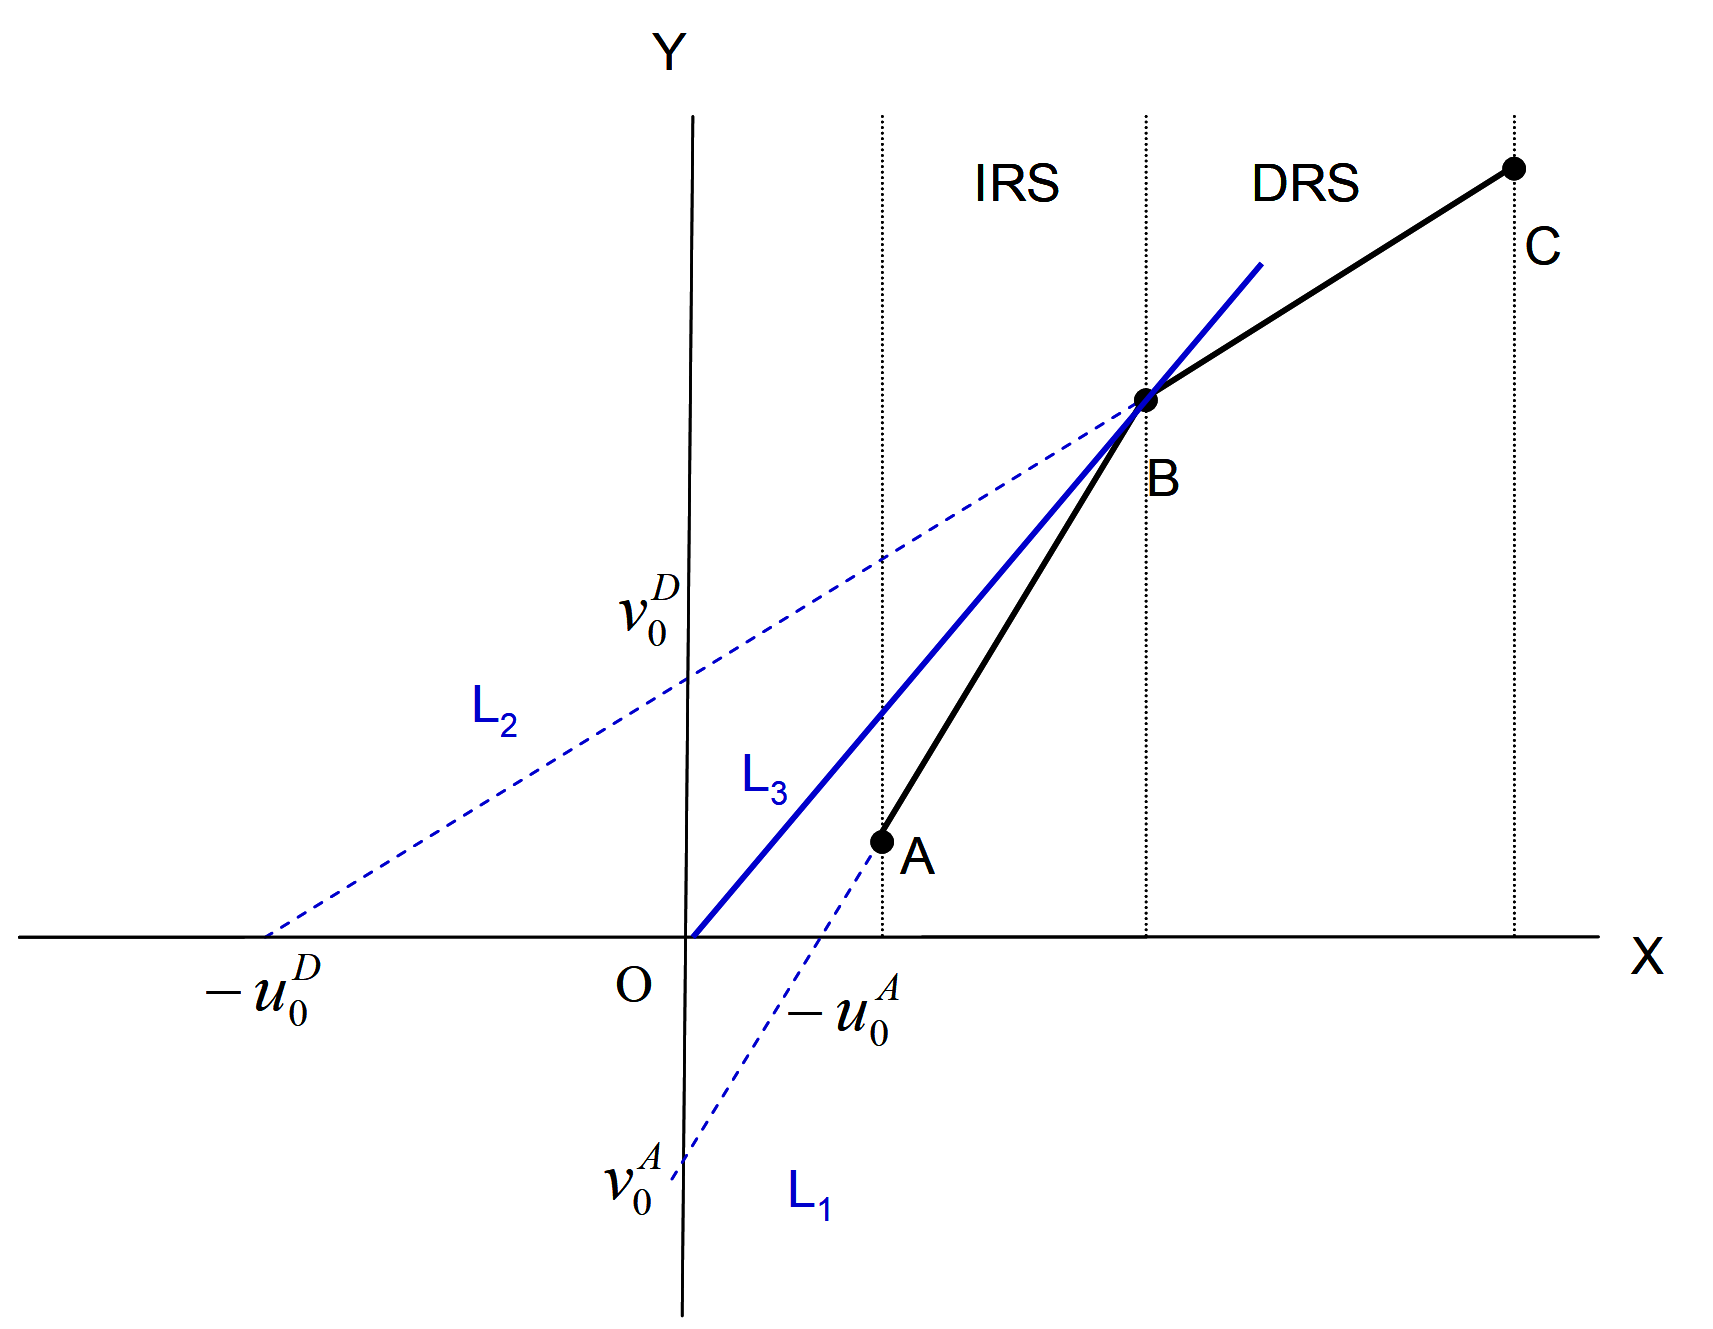

L3（与 $DMU_B$ 相切）达到有效率，其他决策单位都是相对无效率，

L1（与 $DMU_A$ 相切）未通过原点，斜率更大，表示其规模报酬递增，

L2（与 $DMU_C$ 相切）未通过原点，斜率更小，表示其规模报酬递减，

X轴截距为 $-u_0$ (?)，